# DU-PSOR法の例(ヤコビ法)

Copyright (c) 2022 Tadashi Wadayama  
Released under the MIT license  
https://opensource.org/licenses/mit-license.php

In [1]:
using LinearAlgebra
using Plots
gr()
using Random
Random.seed!(1)
using Flux

## 準備(グローバル定数の設定)

In [2]:
n = 32
num_itr = 20
K = 100
max_inner = 50
train_depth = 20
adam_lr = 0.01
M = 0.05randn(n,n)
P = 0.15I + M'*M;

### ミニバッチ生成関数

In [3]:
function mini_batch(K)
    q = randn(n, K)
    x_sol = zeros(n, K)
    for j in 1:K
        x_sol[:,j] = P\q[:,j]
    end
    return q, x_sol
end

mini_batch (generic function with 1 method)

### オリジナルのヤコビ法

In [4]:
function Jacobi_itr(max_itr, q)
    x = zeros(n, K)
    D = diagm(diag(P))
    Dinv = inv(D)
    A = -Dinv * (P - D)
    b = Dinv*q
    for i in 1:max_itr
        x = A*x + b
    end
    return x
end

Jacobi_itr (generic function with 1 method)

In [5]:
function comp_mse(max_itr)
    se = 0.0
    q, x_sol = mini_batch(K)
    x̂ = Jacobi_itr(max_itr, q)
    return norm(x̂ - x_sol)^2/K
end

comp_mse (generic function with 1 method)

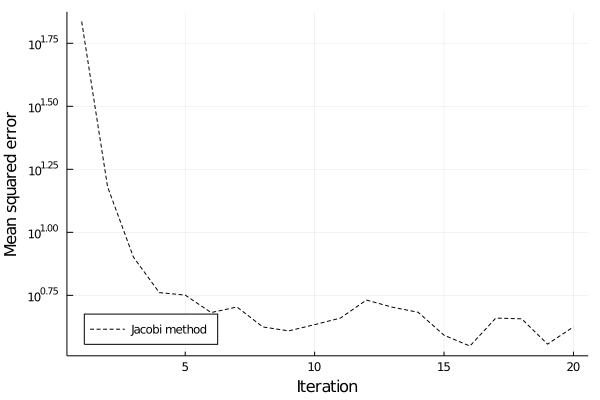

In [6]:
Jacobi_mse = [comp_mse(i) for i in 1:num_itr];
plot(1:num_itr, Jacobi_mse, lw=1, yscale=:log10, label="Jacobi method", color=:black, ls=:dash, xlabel="Iteration", ylabel="Mean squared error", legend=:bottomleft)

### DU-PSOR反復の定義 

In [7]:
function DU_PSOR(q, max_itr, ω, T)
    x = zeros(n, K)
    D = diagm(diag(P))
    Dinv = inv(D)
    A = -Dinv * (P - D)
    b = Dinv*q
    for i in 0:max_itr-1
        k = (i % T)+1 
        x = x + ω[k]*(A*x+b - x)
    end
    return x
end

DU_PSOR (generic function with 1 method)

### 損失関数の定義

In [8]:
function loss(x_fixed, x̂)
    return norm(x_fixed - x̂)^2/K
end     

loss (generic function with 1 method)

### 訓練関数の定義

In [9]:
function train(opt, ω, T)
    ps = Flux.params(ω)
    for itr in 1:train_depth
        for i in 1:max_inner 
            q, x_sol = mini_batch(K)
            gs = Flux.gradient(ps) do
                x_hat = DU_PSOR(q, itr, ω, T)
                loss(x_sol, x_hat)
            end
            Flux.Optimise.update!(opt, ps, gs) 
        end
        q, x_sol = mini_batch(K)
        x̂ = DU_PSOR(q, itr, ω, T)
        println(loss(x_sol, x̂))
    end
end

train (generic function with 1 method)

In [10]:
function comp_mse_DUPSOR(max_itr, ω, T)
    q, x_sol = mini_batch(K)
    x̂ = DU_PSOR(q, max_itr, ω, T)
    return loss(x_sol, x̂)
end

comp_mse_DUPSOR (generic function with 1 method)

### 学習過程

60.836850564534245
13.700651790766317
3.674822190806478
0.9133401580314497
0.23798800954842933
0.05736927149411717
0.015954083345554437
0.006177573410347467
0.0015294859849110528
0.0004801549833459963
0.00015139682354791943
6.888650063268132e-5
2.4946963159951153e-5
9.777172249640556e-6
4.30124524139912e-6
1.1667305365879622e-6
4.2988279264704106e-7
2.251340280469579e-7
8.765405422331188e-8
2.4809248290253366e-8


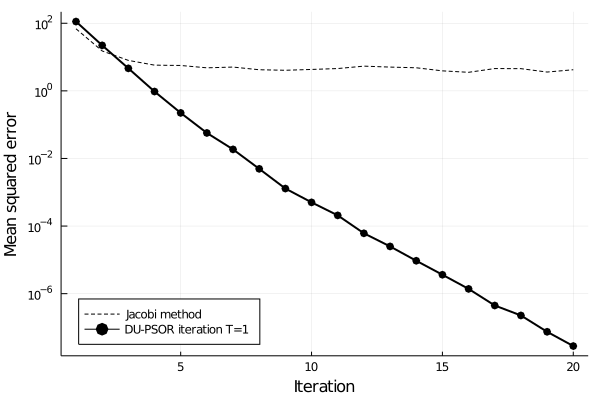

In [11]:
T = 1
ω_train = ones(T)
opt = ADAM(adam_lr)
train(opt, ω_train, T)
DUPSOR_mse =[comp_mse_DUPSOR(i, ω_train, T) for i in 1:num_itr]
plot!(1:num_itr, DUPSOR_mse, lw=2, label="DU-PSOR iteration T="*string(T), color=:black, marker=:o)

61.14431868916351
6.507995377094134
1.1217895954068215
0.1660664292265119
0.02570717952803482
0.004230483826006339
0.0006656213426079784
0.00010286121491644181
1.5010116558964312e-5
2.686364764362279e-6
4.22457085754548e-7
7.160121060480477e-8
1.1657758020657062e-8
2.1762628246834137e-9
3.038837274601804e-10
5.611940825432894e-11
7.758596609432552e-12
1.7572708306690847e-12
2.3262057534141653e-13
6.733251489762596e-14


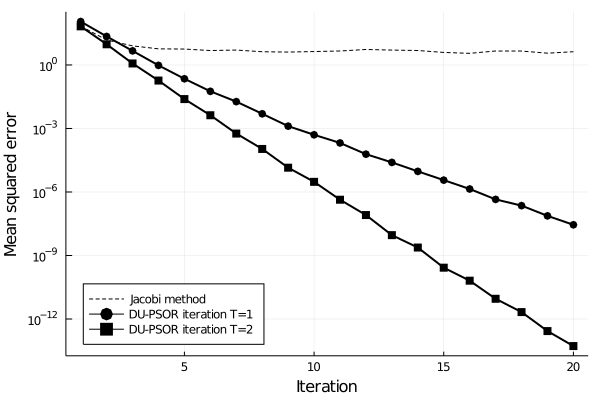

In [12]:
T = 2
ω_train = ones(T)
opt = ADAM(adam_lr)
train(opt, ω_train, T)
DUPSOR_mse =[comp_mse_DUPSOR(i, ω_train, T) for i in 1:num_itr]
plot!(1:num_itr, DUPSOR_mse, lw=2, label="DU-PSOR iteration T="*string(T), color=:black, marker=:rect)

64.41193954578038
6.122188829953294
0.6192982752978916
0.09977980976016466
0.006929010025164214
0.0006560334349755778
5.8854771151907626e-5
6.704793018337793e-6
1.4368910323847753e-6
1.3648500248567226e-7
1.3779386565019966e-8
7.545351660808881e-9
1.434199194129551e-10
1.7981169197790415e-11
2.7279986752724673e-12
4.68942675177235e-13
2.475293111273323e-13
5.817144651330062e-15
1.2221070114736677e-15
5.595388772010898e-16


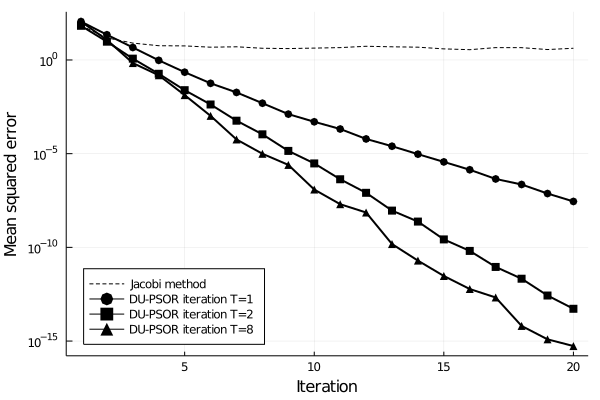

In [13]:
T = 8
ω_train = ones(T)
opt = ADAM(adam_lr)
train(opt, ω_train, T)
DUPSOR_mse =[comp_mse_DUPSOR(i, ω_train, T) for i in 1:num_itr]
plot!(1:num_itr, DUPSOR_mse, lw=2, label="DU-PSOR iteration T="*string(T), color=:black, marker=:utriangle)

In [14]:
savefig("DU-PSOR-Jacobi.pdf")